In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import time
import os
import pickle
import json
import timeit
import datetime
from copy import deepcopy as copy

In [2]:
import torch
from torch.nn import functional as F
torch.cuda.empty_cache()
DTYPE = torch.float32
DEVICE = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda', index=3)

In [3]:
import sys
sys.path.append('../../')

In [4]:
import IPS_surrogate_util as util

In [5]:
beam_frequency = 80.5e6
wavelength = 299792458 / beam_frequency
phase_scan = np.arange(256)/256*2*np.pi-np.pi

cav_type_name = 'QWR041' 

In [6]:
WuLEVEL = 3
TEST = False

BATCH_SIZE = 2**13 #8192
LR = '1E-4'
DROPOUT = False

validation_split = 0.3
hidden_nodes = [128,64,64,64,64]
linear_nodes = 256
activation = torch.nn.ELU()

lr_scheduler = {'final_div_factor':1e3}

In [7]:
import sys
sys.path.insert(0, '/home/hwang/libIPS')

from info import info
for k,v in info.items():
    print(k)
    for k_,v_ in v.items():
        print(' ',k_+' '*(22-len(k_)),v_)

In [8]:
W_u_range = info[cav_type_name]['W_u_range']
field_amplitude_range = info[cav_type_name]['field_amplitude_range']
qA_range = info[cav_type_name]['qA_range']
cav_length = info[cav_type_name]['cav_length']
nLEVEL = info[cav_type_name]['nLEVEL']

In [9]:
dW_LEVEL = (W_u_range[1]-W_u_range[0])/nLEVEL
W_u_min = W_u_range[0] +WuLEVEL*dW_LEVEL 
W_u_max = W_u_range[0] +WuLEVEL*dW_LEVEL + 1.0*dW_LEVEL

In [10]:
DATA_PATH = "./data/"
MODEL_PATH = "./WuLEVEL"+str(WuLEVEL)#+"_batchsize"+str(BATCH_SIZE)+"_lr"+LR+'_'+'dtype'+str(DTYPE)[-2:]
if DTYPE == torch.float64:
    MODEL_PATH += '_dtype'+str(DTYPE)[-2:]
MODEL_PATH += '/'
LR = float(LR)
os.makedirs(MODEL_PATH, exist_ok=True)

In [11]:
EPOCHs = 6000  # may increase later... 
if TEST:
    EPOCHs = 100 #int(0.01*EPOCHs)

In [12]:
def Wu2beta(w_u):
    gamma = 1.+w_u/931.5e6
    return np.sqrt(1.0 - 1.0 / gamma ** 2)
def beta2Wu(beta):
    gamma = np.sqrt(1./(1.-beta**2))
    return (gamma-1.)*931.5e6

# Read data of selected Wu level

In [13]:
fname = os.path.join(DATA_PATH,cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
# fname = os.path.join('./',cav_type_name+'_pd'+str(WuLEVEL)+'.pkl')
df = pd.DataFrame(pickle.load(open(fname,'rb')))
df.columns

Index(['phase', 'W/u in', 'Cav amplitude in', 'qA', 'dTau', 'dW_u'], dtype='object')

### construct minmax scalar

In [14]:
Y_LABELs = ['dTau', 'dW_u']
y = df[Y_LABELs].values

Y_MIN = y.min(axis=0) #util.format_floats(y.min(axis=0),num_digits=4)
Y_MAX = y.max(axis=0) #util.format_floats(y.max(axis=0),num_digits=4)
print("Y_LABELs",Y_LABELs)
print("Y_MIN",Y_MIN)
print("Y_MAX",Y_MAX)
print("y.shape",y.shape)

Y_LABELs ['dTau', 'dW_u']
Y_MIN [-2.41225044e-03 -2.19871505e+06]
Y_MAX [2.36285424e-03 2.19721743e+06]
y.shape (134217728, 2)


In [15]:
X_LABELs = ['phase', 'W/u in', 'Cav amplitude in', 'qA']
x = df[X_LABELs].values

X_MIN = [ 0,W_u_min,                       0, qA_range[0]]
X_MAX = [ 1,W_u_max,field_amplitude_range[1], qA_range[1]] 

print("X_LABELs",X_LABELs)
print("X_MIN",X_MIN)
print("X_MAX",X_MAX)

X_LABELs ['phase', 'W/u in', 'Cav amplitude in', 'qA']
X_MIN [0, 233750000.0, 0, 0.2]
X_MAX [1, 300000000.0, 7.4, 0.6]


In [16]:
normalization_info = {'xmin':X_MIN,'xmax':X_MAX,
                      'ymin':Y_MIN,'ymax':Y_MAX,
                      'fname':MODEL_PATH+'scalar_info.pkl'}
scalar = util.scalar(**normalization_info)

### apply normalization

In [17]:
# p = np.random.permutation(len(x))
# x = x[p]
# y = y[p]

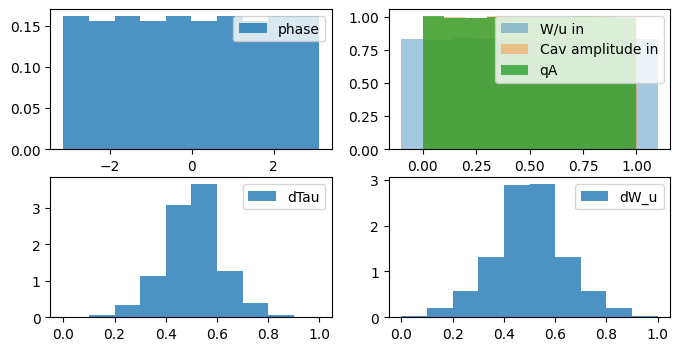

In [18]:
xn = scalar.normalize_x(x)
yn = scalar.normalize_y(y)
fig,ax = plt.subplots(2,2,figsize=(8,4))
ax[0,0].hist(xn[:,0],alpha=0.8,density=True,label=X_LABELs[0]);
ax[0,0].legend()
ax[0,1].hist(xn[:,1],alpha=0.4,density=True,label=X_LABELs[1]);
ax[0,1].hist(xn[:,2],alpha=0.4,density=True,label=X_LABELs[2]);
ax[0,1].hist(xn[:,3],alpha=0.8,density=True,label=X_LABELs[3]);
ax[0,1].legend()
ax[1,0].hist(yn[:,0],alpha=0.8,density=True,label=Y_LABELs[0]);
ax[1,0].legend()
ax[1,1].hist(yn[:,1],alpha=0.8,density=True,label=Y_LABELs[1]);
ax[1,1].legend()

# Train 

In [19]:
model, model_info = util.construct_model(
                                        input_dim  = xn.shape[1],
                                        output_dim  = yn.shape[1],
                                        input_phase_feature_dim = 1,        
                                        linear_nodes = linear_nodes,
                                        hidden_nodes = hidden_nodes,
                                        activation = activation)
model.to(DEVICE).to(DTYPE);

In [20]:
p = model.parameters().__next__()
p.dtype, p.device

(torch.float32, device(type='cuda', index=3))

In [21]:
json.dump(model_info,open(MODEL_PATH+'model_info.json','w'))
model_info

{'input_dim': 4,
 'output_dim': 2,
 'input_phase_feature_dim': 1,
 'linear_nodes': [256],
 'hidden_nodes': [128, 64, 32, 64, 32],
 'activation': 'ELU'}

In [22]:
torch.nn.MSELoss.__name__

'MSELoss'

In [23]:
train_info = {
    'epochs':EPOCHs,
    'lr':LR,
    'batch_size':BATCH_SIZE,
    'criterion': torch.nn.MSELoss.__name__,
    'optimizer': torch.optim.Adam.__name__,
    'optim_args': None,
    'lr_scheduler': lr_scheduler,
    'dropout_stabilization': DROPOUT,
    'shuffle':True,
    'load_best':True,
    'validation_split':validation_split,
    'fname_model'  : MODEL_PATH + 'model.pt',
    'fname_opt'    : MODEL_PATH + 'optimizer.pt',
    'fname_history': MODEL_PATH + 'train_history.pkl'\
}

In [ ]:
history,model_state_dict,opt_state_dict = util.train(
    model,xn,yn,
    **train_info,
    verbose = True,
    )

Train Function Arguments: 2024-02-29 18:05
  - model: _ModelWithPhaseInput
  - x: (134217728, 4)
  - y: (134217728, 2)
  - epochs: 5000
  - lr: 0.0001
  - batch_size: 8192
  - shuffle: True
  - validation_split: 0.3
  - criterion: MSELoss
  - optimizer: Adam
  - optim_args: None
  - optimizer_state_dict: None
  - lr_scheduler: {'final_div_factor': 1000.0}
  - dropout_stabilization: False
  - prev_history: None
  - load_best: True
  - training_timeout: inf
  - verbose: True
  - fname_model: ./WuLEVEL3/model.pt
  - fname_opt: ./WuLEVEL3/optimizer.pt
  - fname_history: ./WuLEVEL3/train_history.pkl

Model Paramers:
  - name: linear_base.0.weight, shape: torch.Size([256, 5]), dtype: torch.float32, device: cuda:3
  - name: linear_base.0.bias, shape: torch.Size([256]), dtype: torch.float32, device: cuda:3
  - name: linear_base.1.weight, shape: torch.Size([2, 256]), dtype: torch.float32, device: cuda:3
  - name: linear_base.1.bias, shape: torch.Size([2]), dtype: torch.float32, device: cuda:3
 

 Epoch 0067: | Train Loss: 1.20E-07 | Val Loss: 1.18E-07 | lr: 2.50E-05 | 0:33:46.545319
 Epoch 0068: | Train Loss: 1.20E-07 | Val Loss: 8.77E-08 | lr: 2.55E-05 | 0:34:13.648423
 Epoch 0069: | Train Loss: 1.21E-07 | Val Loss: 9.23E-08 | lr: 2.59E-05 | 0:34:39.649249
 Epoch 0070: | Train Loss: 1.22E-07 | Val Loss: 8.65E-08 | lr: 2.63E-05 | 0:35:05.417032
 Epoch 0071: | Train Loss: 1.22E-07 | Val Loss: 2.75E-07 | lr: 2.68E-05 | 0:35:30.617269
 Epoch 0072: | Train Loss: 1.23E-07 | Val Loss: 2.06E-07 | lr: 2.72E-05 | 0:35:56.826578
 Epoch 0073: | Train Loss: 1.24E-07 | Val Loss: 8.74E-08 | lr: 2.76E-05 | 0:36:23.759173
 Epoch 0074: | Train Loss: 1.25E-07 | Val Loss: 1.13E-07 | lr: 2.81E-05 | 0:36:49.769579
 Epoch 0075: | Train Loss: 1.26E-07 | Val Loss: 8.54E-08 | lr: 2.85E-05 | 0:37:15.381363
 Epoch 0076: | Train Loss: 1.28E-07 | Val Loss: 1.67E-07 | lr: 2.90E-05 | 0:37:42.128989
 Epoch 0077: | Train Loss: 1.29E-07 | Val Loss: 1.22E-07 | lr: 2.95E-05 | 0:38:09.707324
 Epoch 0078: | Train 

 Epoch 0160: | Train Loss: 3.94E-07 | Val Loss: 2.45E-07 | lr: 7.42E-05 | 1:14:35.601496
 Epoch 0161: | Train Loss: 3.96E-07 | Val Loss: 1.93E-07 | lr: 7.47E-05 | 1:15:04.519045
 Epoch 0162: | Train Loss: 3.98E-07 | Val Loss: 8.74E-08 | lr: 7.52E-05 | 1:15:29.965870
 Epoch 0163: | Train Loss: 4.00E-07 | Val Loss: 7.94E-08 | lr: 7.57E-05 | 1:15:56.879961
 Epoch 0164: | Train Loss: 4.03E-07 | Val Loss: 3.75E-07 | lr: 7.62E-05 | 1:16:23.091959
 Epoch 0165: | Train Loss: 4.05E-07 | Val Loss: 7.65E-07 | lr: 7.67E-05 | 1:16:49.563318
 Epoch 0166: | Train Loss: 4.02E-07 | Val Loss: 1.68E-07 | lr: 7.72E-05 | 1:17:17.033781
 Epoch 0167: | Train Loss: 4.07E-07 | Val Loss: 2.18E-07 | lr: 7.77E-05 | 1:17:45.143288
 Epoch 0168: | Train Loss: 4.09E-07 | Val Loss: 8.06E-08 | lr: 7.81E-05 | 1:18:11.596419
 Epoch 0169: | Train Loss: 4.11E-07 | Val Loss: 3.82E-07 | lr: 7.86E-05 | 1:18:46.768209
 Epoch 0170: | Train Loss: 4.10E-07 | Val Loss: 2.20E-07 | lr: 7.91E-05 | 1:19:12.261826
 Epoch 0171: | Train 

 Epoch 0253: | Train Loss: 3.05E-07 | Val Loss: 1.28E-07 | lr: 1.00E-04 | 1:56:39.132044
 Epoch 0254: | Train Loss: 3.00E-07 | Val Loss: 8.90E-07 | lr: 1.00E-04 | 1:57:05.078238
 Epoch 0255: | Train Loss: 2.99E-07 | Val Loss: 3.71E-08 | lr: 1.00E-04 | 1:57:31.734471
 Epoch 0256: | Train Loss: 2.96E-07 | Val Loss: 5.30E-08 | lr: 1.00E-04 | 1:57:57.616989
 Epoch 0257: | Train Loss: 2.94E-07 | Val Loss: 2.61E-07 | lr: 1.00E-04 | 1:58:23.088278
 Epoch 0258: | Train Loss: 2.92E-07 | Val Loss: 2.12E-07 | lr: 1.00E-04 | 1:58:49.296932
 Epoch 0259: | Train Loss: 2.89E-07 | Val Loss: 7.81E-07 | lr: 1.00E-04 | 1:59:15.956298
 Epoch 0260: | Train Loss: 2.86E-07 | Val Loss: 8.51E-08 | lr: 1.00E-04 | 1:59:41.749032
 Epoch 0261: | Train Loss: 2.84E-07 | Val Loss: 9.68E-07 | lr: 1.00E-04 | 2:00:07.810960
 Epoch 0262: | Train Loss: 2.81E-07 | Val Loss: 2.11E-07 | lr: 1.00E-04 | 2:00:34.200759
 Epoch 0263: | Train Loss: 2.80E-07 | Val Loss: 4.74E-08 | lr: 1.00E-04 | 2:01:01.099665
 Epoch 0264: | Train 

 Epoch 0346: | Train Loss: 1.64E-07 | Val Loss: 7.64E-08 | lr: 9.99E-05 | 2:38:05.403932
 Epoch 0347: | Train Loss: 1.63E-07 | Val Loss: 2.31E-07 | lr: 9.99E-05 | 2:38:30.976057
 Epoch 0348: | Train Loss: 1.63E-07 | Val Loss: 4.28E-08 | lr: 9.99E-05 | 2:38:58.853091
 Epoch 0349: | Train Loss: 1.62E-07 | Val Loss: 1.78E-07 | lr: 9.99E-05 | 2:39:24.080661
 Epoch 0350: | Train Loss: 1.61E-07 | Val Loss: 3.36E-08 | lr: 9.99E-05 | 2:39:49.768836
 Epoch 0351: | Train Loss: 1.60E-07 | Val Loss: 1.07E-07 | lr: 9.99E-05 | 2:40:14.668468
 Epoch 0352: | Train Loss: 1.59E-07 | Val Loss: 4.23E-08 | lr: 9.99E-05 | 2:40:39.851106
 Epoch 0353: | Train Loss: 1.58E-07 | Val Loss: 4.29E-07 | lr: 9.99E-05 | 2:41:05.809017
 Epoch 0354: | Train Loss: 1.57E-07 | Val Loss: 7.21E-08 | lr: 9.99E-05 | 2:41:31.243101
 Epoch 0355: | Train Loss: 1.56E-07 | Val Loss: 1.34E-07 | lr: 9.99E-05 | 2:41:56.646705
 Epoch 0356: | Train Loss: 1.56E-07 | Val Loss: 9.18E-08 | lr: 9.99E-05 | 2:42:23.100538
 Epoch 0357: | Train 

 Epoch 0439: | Train Loss: 1.05E-07 | Val Loss: 9.35E-08 | lr: 9.96E-05 | 3:23:36.876648
 Epoch 0440: | Train Loss: 1.04E-07 | Val Loss: 1.83E-08 | lr: 9.96E-05 | 3:24:07.284670
 Epoch 0441: | Train Loss: 1.04E-07 | Val Loss: 8.79E-08 | lr: 9.96E-05 | 3:24:34.854709
 Epoch 0442: | Train Loss: 1.03E-07 | Val Loss: 6.69E-08 | lr: 9.96E-05 | 3:25:03.634249
 Epoch 0443: | Train Loss: 1.02E-07 | Val Loss: 3.97E-07 | lr: 9.96E-05 | 3:25:30.193454
 Epoch 0444: | Train Loss: 1.02E-07 | Val Loss: 9.57E-08 | lr: 9.96E-05 | 3:25:57.433778
 Epoch 0445: | Train Loss: 1.01E-07 | Val Loss: 2.83E-08 | lr: 9.96E-05 | 3:26:24.940805
 Epoch 0446: | Train Loss: 1.01E-07 | Val Loss: 3.21E-07 | lr: 9.96E-05 | 3:26:55.828812
 Epoch 0447: | Train Loss: 1.01E-07 | Val Loss: 3.65E-08 | lr: 9.96E-05 | 3:27:26.568339
 Epoch 0448: | Train Loss: 1.00E-07 | Val Loss: 2.73E-08 | lr: 9.96E-05 | 3:28:00.815994
 Epoch 0449: | Train Loss: 9.96E-08 | Val Loss: 5.84E-08 | lr: 9.96E-05 | 3:28:26.841862
 Epoch 0450: | Train 

 Epoch 0532: | Train Loss: 7.07E-08 | Val Loss: 3.29E-08 | lr: 9.91E-05 | 4:06:43.591045
 Epoch 0533: | Train Loss: 7.07E-08 | Val Loss: 2.32E-08 | lr: 9.91E-05 | 4:07:14.059543
 Epoch 0534: | Train Loss: 7.02E-08 | Val Loss: 1.73E-08 | lr: 9.91E-05 | 4:07:41.387037
 Epoch 0535: | Train Loss: 7.00E-08 | Val Loss: 2.50E-07 | lr: 9.91E-05 | 4:08:07.094634
 Epoch 0536: | Train Loss: 6.96E-08 | Val Loss: 4.65E-08 | lr: 9.91E-05 | 4:08:33.113926
 Epoch 0537: | Train Loss: 6.96E-08 | Val Loss: 5.04E-08 | lr: 9.91E-05 | 4:09:05.853210
 Epoch 0538: | Train Loss: 6.92E-08 | Val Loss: 1.96E-08 | lr: 9.91E-05 | 4:09:37.363895
 Epoch 0539: | Train Loss: 6.90E-08 | Val Loss: 9.60E-09 | lr: 9.91E-05 | 4:10:03.794009
 Epoch 0540: | Train Loss: 6.86E-08 | Val Loss: 1.08E-07 | lr: 9.91E-05 | 4:10:29.808086
 Epoch 0541: | Train Loss: 6.84E-08 | Val Loss: 4.79E-08 | lr: 9.91E-05 | 4:10:56.661706
 Epoch 0542: | Train Loss: 6.80E-08 | Val Loss: 1.26E-08 | lr: 9.91E-05 | 4:11:29.425512
 Epoch 0543: | Train 

 Epoch 0625: | Train Loss: 5.00E-08 | Val Loss: 1.63E-08 | lr: 9.85E-05 | 4:49:03.408802
 Epoch 0626: | Train Loss: 4.98E-08 | Val Loss: 9.11E-09 | lr: 9.85E-05 | 4:49:30.639614
 Epoch 0627: | Train Loss: 4.95E-08 | Val Loss: 8.41E-08 | lr: 9.85E-05 | 4:49:57.321880
 Epoch 0628: | Train Loss: 4.95E-08 | Val Loss: 3.12E-08 | lr: 9.84E-05 | 4:50:28.208117
 Epoch 0629: | Train Loss: 4.91E-08 | Val Loss: 9.97E-08 | lr: 9.84E-05 | 4:50:54.075324
 Epoch 0630: | Train Loss: 4.91E-08 | Val Loss: 2.61E-08 | lr: 9.84E-05 | 4:51:19.777683
 Epoch 0631: | Train Loss: 4.90E-08 | Val Loss: 6.54E-09 | lr: 9.84E-05 | 4:51:46.086315
 Epoch 0632: | Train Loss: 4.86E-08 | Val Loss: 1.61E-07 | lr: 9.84E-05 | 4:52:11.818417
 Epoch 0633: | Train Loss: 4.86E-08 | Val Loss: 1.05E-08 | lr: 9.84E-05 | 4:52:37.817805
 Epoch 0634: | Train Loss: 4.85E-08 | Val Loss: 4.60E-08 | lr: 9.84E-05 | 4:53:03.536805
 Epoch 0635: | Train Loss: 4.81E-08 | Val Loss: 1.41E-08 | lr: 9.84E-05 | 4:53:30.026267
 Epoch 0636: | Train 

 Epoch 0718: | Train Loss: 3.62E-08 | Val Loss: 1.60E-08 | lr: 9.76E-05 | 5:31:00.999592
 Epoch 0719: | Train Loss: 3.60E-08 | Val Loss: 8.30E-09 | lr: 9.76E-05 | 5:31:26.920662
 Epoch 0720: | Train Loss: 3.59E-08 | Val Loss: 1.19E-08 | lr: 9.76E-05 | 5:31:53.390441
 Epoch 0721: | Train Loss: 3.56E-08 | Val Loss: 1.03E-08 | lr: 9.76E-05 | 5:32:20.327001
 Epoch 0722: | Train Loss: 3.56E-08 | Val Loss: 5.87E-09 | lr: 9.76E-05 | 5:32:56.032386
 Epoch 0723: | Train Loss: 3.55E-08 | Val Loss: 7.67E-09 | lr: 9.76E-05 | 5:33:30.006679
 Epoch 0724: | Train Loss: 3.55E-08 | Val Loss: 1.33E-08 | lr: 9.76E-05 | 5:33:59.531553
 Epoch 0725: | Train Loss: 3.52E-08 | Val Loss: 3.92E-08 | lr: 9.76E-05 | 5:34:31.418413
 Epoch 0726: | Train Loss: 3.52E-08 | Val Loss: 5.07E-08 | lr: 9.75E-05 | 5:34:59.079944
 Epoch 0727: | Train Loss: 3.50E-08 | Val Loss: 8.59E-09 | lr: 9.75E-05 | 5:35:30.818579
 Epoch 0728: | Train Loss: 3.49E-08 | Val Loss: 4.06E-08 | lr: 9.75E-05 | 5:35:58.525398
 Epoch 0729: | Train 

 Epoch 0811: | Train Loss: 2.71E-08 | Val Loss: 9.12E-09 | lr: 9.66E-05 | 6:15:46.872855
 Epoch 0812: | Train Loss: 2.70E-08 | Val Loss: 1.26E-08 | lr: 9.66E-05 | 6:16:16.775408
 Epoch 0813: | Train Loss: 2.70E-08 | Val Loss: 2.63E-08 | lr: 9.66E-05 | 6:16:45.512352
 Epoch 0814: | Train Loss: 2.69E-08 | Val Loss: 9.37E-09 | lr: 9.66E-05 | 6:17:17.384837
 Epoch 0815: | Train Loss: 2.69E-08 | Val Loss: 3.20E-08 | lr: 9.65E-05 | 6:17:50.986038
 Epoch 0816: | Train Loss: 2.68E-08 | Val Loss: 1.05E-07 | lr: 9.65E-05 | 6:18:23.665358
 Epoch 0817: | Train Loss: 2.67E-08 | Val Loss: 8.78E-08 | lr: 9.65E-05 | 6:18:51.683632
 Epoch 0818: | Train Loss: 2.66E-08 | Val Loss: 9.44E-08 | lr: 9.65E-05 | 6:19:24.416828
 Epoch 0819: | Train Loss: 2.65E-08 | Val Loss: 8.98E-09 | lr: 9.65E-05 | 6:19:57.797710
 Epoch 0820: | Train Loss: 2.65E-08 | Val Loss: 8.81E-09 | lr: 9.65E-05 | 6:20:26.992549
 Epoch 0821: | Train Loss: 2.64E-08 | Val Loss: 3.85E-08 | lr: 9.65E-05 | 6:21:02.725536
 Epoch 0822: | Train 

 Epoch 0904: | Train Loss: 2.15E-08 | Val Loss: 1.01E-08 | lr: 9.54E-05 | 7:01:04.191267
 Epoch 0905: | Train Loss: 2.15E-08 | Val Loss: 1.34E-07 | lr: 9.54E-05 | 7:01:29.885388
 Epoch 0906: | Train Loss: 2.14E-08 | Val Loss: 8.79E-09 | lr: 9.54E-05 | 7:02:03.253116
 Epoch 0907: | Train Loss: 2.15E-08 | Val Loss: 6.26E-09 | lr: 9.54E-05 | 7:02:32.896249
 Epoch 0908: | Train Loss: 2.13E-08 | Val Loss: 1.08E-08 | lr: 9.53E-05 | 7:03:01.041169
 Epoch 0909: | Train Loss: 2.13E-08 | Val Loss: 9.03E-09 | lr: 9.53E-05 | 7:03:37.101842
 Epoch 0910: | Train Loss: 2.12E-08 | Val Loss: 5.06E-09 | lr: 9.53E-05 | 7:04:05.600234
 Epoch 0911: | Train Loss: 2.12E-08 | Val Loss: 1.24E-08 | lr: 9.53E-05 | 7:04:33.874436
 Epoch 0912: | Train Loss: 2.11E-08 | Val Loss: 2.61E-08 | lr: 9.53E-05 | 7:05:00.020578
 Epoch 0913: | Train Loss: 2.11E-08 | Val Loss: 4.29E-09 | lr: 9.53E-05 | 7:05:27.280274
 Epoch 0914: | Train Loss: 2.10E-08 | Val Loss: 4.44E-09 | lr: 9.53E-05 | 7:05:53.714215
 Epoch 0915: | Train 

 Epoch 0997: | Train Loss: 1.77E-08 | Val Loss: 4.06E-09 | lr: 9.40E-05 | 7:46:45.799963
 Epoch 0998: | Train Loss: 1.77E-08 | Val Loss: 1.10E-08 | lr: 9.40E-05 | 7:47:16.178668
 Epoch 0999: | Train Loss: 1.76E-08 | Val Loss: 1.31E-08 | lr: 9.40E-05 | 7:47:49.044167
 Epoch 1000: | Train Loss: 1.76E-08 | Val Loss: 7.77E-08 | lr: 9.40E-05 | 7:48:20.894156
 Epoch 1001: | Train Loss: 1.76E-08 | Val Loss: 2.79E-08 | lr: 9.40E-05 | 7:48:53.254393
 Epoch 1002: | Train Loss: 1.75E-08 | Val Loss: 2.32E-08 | lr: 9.39E-05 | 7:49:22.788824
 Epoch 1003: | Train Loss: 1.74E-08 | Val Loss: 1.45E-08 | lr: 9.39E-05 | 7:49:48.967649
 Epoch 1004: | Train Loss: 1.74E-08 | Val Loss: 4.83E-08 | lr: 9.39E-05 | 7:50:22.856520
 Epoch 1005: | Train Loss: 1.74E-08 | Val Loss: 1.17E-08 | lr: 9.39E-05 | 7:50:48.922114
 Epoch 1006: | Train Loss: 1.74E-08 | Val Loss: 5.02E-09 | lr: 9.39E-05 | 7:51:18.193968
 Epoch 1007: | Train Loss: 1.73E-08 | Val Loss: 6.99E-09 | lr: 9.39E-05 | 7:51:45.545336
 Epoch 1008: | Train 

 Epoch 1090: | Train Loss: 1.50E-08 | Val Loss: 5.61E-09 | lr: 9.25E-05 | 8:30:01.190298
 Epoch 1091: | Train Loss: 1.50E-08 | Val Loss: 3.30E-08 | lr: 9.25E-05 | 8:30:28.988313
 Epoch 1092: | Train Loss: 1.50E-08 | Val Loss: 5.93E-09 | lr: 9.24E-05 | 8:30:55.744833
 Epoch 1093: | Train Loss: 1.50E-08 | Val Loss: 2.25E-08 | lr: 9.24E-05 | 8:31:23.938722
 Epoch 1094: | Train Loss: 1.49E-08 | Val Loss: 1.15E-08 | lr: 9.24E-05 | 8:31:50.305996
 Epoch 1095: | Train Loss: 1.49E-08 | Val Loss: 3.56E-09 | lr: 9.24E-05 | 8:32:16.713032
 Epoch 1096: | Train Loss: 1.49E-08 | Val Loss: 7.43E-09 | lr: 9.24E-05 | 8:32:43.971546
 Epoch 1097: | Train Loss: 1.48E-08 | Val Loss: 6.77E-08 | lr: 9.24E-05 | 8:33:12.248992
 Epoch 1098: | Train Loss: 1.49E-08 | Val Loss: 5.67E-08 | lr: 9.23E-05 | 8:33:43.874409
 Epoch 1099: | Train Loss: 1.48E-08 | Val Loss: 4.74E-08 | lr: 9.23E-05 | 8:34:12.353286
 Epoch 1100: | Train Loss: 1.48E-08 | Val Loss: 1.67E-08 | lr: 9.23E-05 | 8:34:40.510007
 Epoch 1101: | Train 

 Epoch 1183: | Train Loss: 1.30E-08 | Val Loss: 4.77E-09 | lr: 9.08E-05 | 9:14:16.713133
 Epoch 1184: | Train Loss: 1.30E-08 | Val Loss: 7.40E-09 | lr: 9.08E-05 | 9:14:48.968458
 Epoch 1185: | Train Loss: 1.30E-08 | Val Loss: 4.95E-09 | lr: 9.07E-05 | 9:15:17.768921
 Epoch 1186: | Train Loss: 1.30E-08 | Val Loss: 3.68E-09 | lr: 9.07E-05 | 9:15:51.303412
 Epoch 1187: | Train Loss: 1.30E-08 | Val Loss: 4.58E-09 | lr: 9.07E-05 | 9:16:18.589395
 Epoch 1188: | Train Loss: 1.29E-08 | Val Loss: 9.85E-09 | lr: 9.07E-05 | 9:16:47.371812
 Epoch 1189: | Train Loss: 1.30E-08 | Val Loss: 2.18E-08 | lr: 9.07E-05 | 9:17:13.582748
 Epoch 1190: | Train Loss: 1.28E-08 | Val Loss: 5.85E-09 | lr: 9.06E-05 | 9:17:41.454027
 Epoch 1191: | Train Loss: 1.29E-08 | Val Loss: 3.83E-09 | lr: 9.06E-05 | 9:18:13.812892
 Epoch 1192: | Train Loss: 1.29E-08 | Val Loss: 2.37E-08 | lr: 9.06E-05 | 9:18:43.871500
 Epoch 1193: | Train Loss: 1.28E-08 | Val Loss: 4.52E-09 | lr: 9.06E-05 | 9:19:13.298202
 Epoch 1194: | Train 

 Epoch 1276: | Train Loss: 1.15E-08 | Val Loss: 7.55E-09 | lr: 8.89E-05 | 9:57:32.985030
 Epoch 1277: | Train Loss: 1.15E-08 | Val Loss: 4.02E-09 | lr: 8.89E-05 | 9:58:01.238423
 Epoch 1278: | Train Loss: 1.15E-08 | Val Loss: 3.07E-09 | lr: 8.89E-05 | 9:58:31.214672
 Epoch 1279: | Train Loss: 1.16E-08 | Val Loss: 2.85E-09 | lr: 8.89E-05 | 9:59:02.606228
 Epoch 1280: | Train Loss: 1.13E-08 | Val Loss: 5.80E-09 | lr: 8.88E-05 | 9:59:29.039203
 Epoch 1281: | Train Loss: 1.14E-08 | Val Loss: 3.91E-09 | lr: 8.88E-05 | 9:59:58.002193
 Epoch 1282: | Train Loss: 1.14E-08 | Val Loss: 2.50E-08 | lr: 8.88E-05 | 10:00:26.496286
 Epoch 1283: | Train Loss: 1.14E-08 | Val Loss: 3.97E-08 | lr: 8.88E-05 | 10:00:53.034938
 Epoch 1284: | Train Loss: 1.14E-08 | Val Loss: 3.07E-09 | lr: 8.88E-05 | 10:01:19.827977
 Epoch 1285: | Train Loss: 1.14E-08 | Val Loss: 3.82E-09 | lr: 8.87E-05 | 10:01:46.580004
 Epoch 1286: | Train Loss: 1.14E-08 | Val Loss: 4.45E-09 | lr: 8.87E-05 | 10:02:13.795685
 Epoch 1287: | T

 Epoch 1368: | Train Loss: 1.02E-08 | Val Loss: 4.22E-09 | lr: 8.69E-05 | 10:40:22.321229
 Epoch 1369: | Train Loss: 1.02E-08 | Val Loss: 4.62E-09 | lr: 8.69E-05 | 10:40:48.457191
 Epoch 1370: | Train Loss: 1.02E-08 | Val Loss: 5.78E-09 | lr: 8.69E-05 | 10:41:18.918463
 Epoch 1371: | Train Loss: 1.02E-08 | Val Loss: 9.02E-09 | lr: 8.69E-05 | 10:41:45.774517
 Epoch 1372: | Train Loss: 1.02E-08 | Val Loss: 4.80E-09 | lr: 8.69E-05 | 10:42:15.995536
 Epoch 1373: | Train Loss: 1.01E-08 | Val Loss: 1.84E-08 | lr: 8.68E-05 | 10:42:43.495887
 Epoch 1374: | Train Loss: 1.01E-08 | Val Loss: 3.06E-09 | lr: 8.68E-05 | 10:43:11.477025
 Epoch 1375: | Train Loss: 1.01E-08 | Val Loss: 2.80E-09 | lr: 8.68E-05 | 10:43:37.697697
 Epoch 1376: | Train Loss: 1.01E-08 | Val Loss: 2.83E-09 | lr: 8.68E-05 | 10:44:05.237649
 Epoch 1377: | Train Loss: 1.01E-08 | Val Loss: 2.94E-09 | lr: 8.67E-05 | 10:44:32.380806
 Epoch 1378: | Train Loss: 1.00E-08 | Val Loss: 3.08E-09 | lr: 8.67E-05 | 10:44:59.808363
 Epoch 137

 Epoch 1460: | Train Loss: 9.09E-09 | Val Loss: 5.40E-09 | lr: 8.48E-05 | 11:23:27.892982
 Epoch 1461: | Train Loss: 9.06E-09 | Val Loss: 2.55E-09 | lr: 8.48E-05 | 11:23:56.520990
 Epoch 1462: | Train Loss: 8.96E-09 | Val Loss: 2.73E-09 | lr: 8.48E-05 | 11:24:23.896960
 Epoch 1463: | Train Loss: 9.04E-09 | Val Loss: 1.13E-08 | lr: 8.48E-05 | 11:24:53.072849
 Epoch 1464: | Train Loss: 9.03E-09 | Val Loss: 2.33E-08 | lr: 8.47E-05 | 11:25:21.003595
 Epoch 1465: | Train Loss: 9.03E-09 | Val Loss: 3.44E-09 | lr: 8.47E-05 | 11:25:55.779655
 Epoch 1466: | Train Loss: 8.98E-09 | Val Loss: 7.46E-09 | lr: 8.47E-05 | 11:26:28.600965
 Epoch 1467: | Train Loss: 8.97E-09 | Val Loss: 4.41E-09 | lr: 8.47E-05 | 11:26:58.055490
 Epoch 1468: | Train Loss: 8.96E-09 | Val Loss: 1.01E-08 | lr: 8.46E-05 | 11:27:26.965583
 Epoch 1469: | Train Loss: 9.00E-09 | Val Loss: 2.29E-09 | lr: 8.46E-05 | 11:27:56.335830
 Epoch 1470: | Train Loss: 8.91E-09 | Val Loss: 2.87E-09 | lr: 8.46E-05 | 11:28:25.503948
 Epoch 147

 Epoch 1552: | Train Loss: 8.04E-09 | Val Loss: 2.72E-09 | lr: 8.26E-05 | 12:06:34.032526
 Epoch 1553: | Train Loss: 8.01E-09 | Val Loss: 3.20E-09 | lr: 8.26E-05 | 12:07:02.026903
 Epoch 1554: | Train Loss: 8.02E-09 | Val Loss: 2.66E-09 | lr: 8.25E-05 | 12:07:35.764263
 Epoch 1555: | Train Loss: 7.97E-09 | Val Loss: 4.32E-09 | lr: 8.25E-05 | 12:08:04.506760
 Epoch 1556: | Train Loss: 7.98E-09 | Val Loss: 4.32E-09 | lr: 8.25E-05 | 12:08:33.800010
 Epoch 1557: | Train Loss: 8.00E-09 | Val Loss: 2.40E-09 | lr: 8.25E-05 | 12:09:02.896652
 Epoch 1558: | Train Loss: 7.94E-09 | Val Loss: 1.86E-08 | lr: 8.24E-05 | 12:09:32.736579
 Epoch 1559: | Train Loss: 7.94E-09 | Val Loss: 1.33E-08 | lr: 8.24E-05 | 12:10:00.009196
 Epoch 1560: | Train Loss: 7.97E-09 | Val Loss: 2.31E-09 | lr: 8.24E-05 | 12:10:33.205390
 Epoch 1561: | Train Loss: 7.90E-09 | Val Loss: 6.33E-09 | lr: 8.24E-05 | 12:10:58.331888
 Epoch 1562: | Train Loss: 7.93E-09 | Val Loss: 2.46E-09 | lr: 8.23E-05 | 12:11:25.834590
 Epoch 156

 Epoch 1644: | Train Loss: 7.08E-09 | Val Loss: 6.35E-09 | lr: 8.02E-05 | 12:50:24.688578
 Epoch 1645: | Train Loss: 7.15E-09 | Val Loss: 5.71E-09 | lr: 8.02E-05 | 12:50:52.700472
 Epoch 1646: | Train Loss: 7.11E-09 | Val Loss: 2.67E-09 | lr: 8.02E-05 | 12:51:18.832556
 Epoch 1647: | Train Loss: 7.10E-09 | Val Loss: 2.91E-09 | lr: 8.01E-05 | 12:51:44.932447
 Epoch 1648: | Train Loss: 7.09E-09 | Val Loss: 8.79E-09 | lr: 8.01E-05 | 12:52:11.327898
 Epoch 1649: | Train Loss: 7.11E-09 | Val Loss: 5.11E-09 | lr: 8.01E-05 | 12:52:37.138228
 Epoch 1650: | Train Loss: 7.06E-09 | Val Loss: 6.71E-08 | lr: 8.01E-05 | 12:53:03.691371
 Epoch 1651: | Train Loss: 7.08E-09 | Val Loss: 2.82E-09 | lr: 8.00E-05 | 12:53:30.105408
 Epoch 1652: | Train Loss: 7.05E-09 | Val Loss: 2.78E-09 | lr: 8.00E-05 | 12:53:56.614563
 Epoch 1653: | Train Loss: 7.06E-09 | Val Loss: 3.50E-09 | lr: 8.00E-05 | 12:54:23.961491
 Epoch 1654: | Train Loss: 7.04E-09 | Val Loss: 4.08E-09 | lr: 8.00E-05 | 12:54:51.761591
 Epoch 165

 Epoch 1736: | Train Loss: 6.36E-09 | Val Loss: 3.79E-09 | lr: 7.77E-05 | 13:31:49.415483
 Epoch 1737: | Train Loss: 6.35E-09 | Val Loss: 3.40E-09 | lr: 7.77E-05 | 13:32:16.599824
 Epoch 1738: | Train Loss: 6.33E-09 | Val Loss: 6.29E-09 | lr: 7.77E-05 | 13:32:43.742803
 Epoch 1739: | Train Loss: 6.33E-09 | Val Loss: 2.23E-09 | lr: 7.77E-05 | 13:33:10.631756
 Epoch 1740: | Train Loss: 6.32E-09 | Val Loss: 2.18E-09 | lr: 7.76E-05 | 13:33:36.433698
 Epoch 1741: | Train Loss: 6.32E-09 | Val Loss: 1.99E-09 | lr: 7.76E-05 | 13:34:02.773615
 Epoch 1742: | Train Loss: 6.29E-09 | Val Loss: 9.72E-09 | lr: 7.76E-05 | 13:34:28.295504
 Epoch 1743: | Train Loss: 6.31E-09 | Val Loss: 1.63E-08 | lr: 7.75E-05 | 13:34:55.027918
 Epoch 1744: | Train Loss: 6.30E-09 | Val Loss: 2.80E-09 | lr: 7.75E-05 | 13:35:21.981554
 Epoch 1745: | Train Loss: 6.30E-09 | Val Loss: 1.77E-09 | lr: 7.75E-05 | 13:35:49.980565
 Epoch 1746: | Train Loss: 6.28E-09 | Val Loss: 2.07E-09 | lr: 7.75E-05 | 13:36:21.799480
 Epoch 174

 Epoch 1828: | Train Loss: 5.66E-09 | Val Loss: 5.80E-09 | lr: 7.52E-05 | 14:13:33.305051
 Epoch 1829: | Train Loss: 5.64E-09 | Val Loss: 3.81E-09 | lr: 7.51E-05 | 14:13:59.258041
 Epoch 1830: | Train Loss: 5.65E-09 | Val Loss: 2.16E-09 | lr: 7.51E-05 | 14:14:24.903227
 Epoch 1831: | Train Loss: 5.63E-09 | Val Loss: 2.68E-09 | lr: 7.51E-05 | 14:14:51.638607
 Epoch 1832: | Train Loss: 5.62E-09 | Val Loss: 4.45E-09 | lr: 7.50E-05 | 14:15:18.328629
 Epoch 1833: | Train Loss: 5.61E-09 | Val Loss: 3.52E-09 | lr: 7.50E-05 | 14:15:45.290268
 Epoch 1834: | Train Loss: 5.62E-09 | Val Loss: 2.23E-09 | lr: 7.50E-05 | 14:16:12.799189
 Epoch 1835: | Train Loss: 5.62E-09 | Val Loss: 2.12E-09 | lr: 7.50E-05 | 14:16:40.234791
 Epoch 1836: | Train Loss: 5.60E-09 | Val Loss: 3.82E-09 | lr: 7.49E-05 | 14:17:06.404340
 Epoch 1837: | Train Loss: 5.58E-09 | Val Loss: 1.95E-09 | lr: 7.49E-05 | 14:17:32.103359
 Epoch 1838: | Train Loss: 5.59E-09 | Val Loss: 6.84E-09 | lr: 7.49E-05 | 14:17:57.777378
 Epoch 183

 Epoch 1920: | Train Loss: 5.02E-09 | Val Loss: 3.63E-09 | lr: 7.25E-05 | 14:56:17.338812
 Epoch 1921: | Train Loss: 5.02E-09 | Val Loss: 2.80E-09 | lr: 7.25E-05 | 14:56:43.345004
 Epoch 1922: | Train Loss: 5.01E-09 | Val Loss: 4.79E-09 | lr: 7.24E-05 | 14:57:09.318567
 Epoch 1923: | Train Loss: 5.00E-09 | Val Loss: 1.68E-09 | lr: 7.24E-05 | 14:57:35.450386
 Epoch 1924: | Train Loss: 4.98E-09 | Val Loss: 2.17E-09 | lr: 7.24E-05 | 14:58:01.486223
 Epoch 1925: | Train Loss: 4.99E-09 | Val Loss: 4.80E-09 | lr: 7.23E-05 | 14:58:31.451274
 Epoch 1926: | Train Loss: 4.98E-09 | Val Loss: 4.15E-09 | lr: 7.23E-05 | 14:58:57.957251
 Epoch 1927: | Train Loss: 4.98E-09 | Val Loss: 6.29E-09 | lr: 7.23E-05 | 14:59:24.995755
 Epoch 1928: | Train Loss: 4.96E-09 | Val Loss: 1.86E-09 | lr: 7.22E-05 | 14:59:51.397681
 Epoch 1929: | Train Loss: 4.95E-09 | Val Loss: 2.13E-09 | lr: 7.22E-05 | 15:00:17.247932
 Epoch 1930: | Train Loss: 4.95E-09 | Val Loss: 1.84E-09 | lr: 7.22E-05 | 15:00:43.147677
 Epoch 193

 Epoch 2012: | Train Loss: 4.46E-09 | Val Loss: 2.21E-09 | lr: 6.97E-05 | 15:38:32.121795
 Epoch 2013: | Train Loss: 4.44E-09 | Val Loss: 5.56E-09 | lr: 6.97E-05 | 15:38:57.641862
 Epoch 2014: | Train Loss: 4.46E-09 | Val Loss: 9.53E-09 | lr: 6.97E-05 | 15:39:24.148739
 Epoch 2015: | Train Loss: 4.42E-09 | Val Loss: 3.98E-09 | lr: 6.96E-05 | 15:39:50.503017
 Epoch 2016: | Train Loss: 4.43E-09 | Val Loss: 2.91E-09 | lr: 6.96E-05 | 15:40:17.779385
 Epoch 2017: | Train Loss: 4.43E-09 | Val Loss: 3.13E-09 | lr: 6.96E-05 | 15:40:46.710402
 Epoch 2018: | Train Loss: 4.41E-09 | Val Loss: 1.71E-09 | lr: 6.95E-05 | 15:41:13.586529
 Epoch 2019: | Train Loss: 4.41E-09 | Val Loss: 7.91E-09 | lr: 6.95E-05 | 15:41:39.707198
 Epoch 2020: | Train Loss: 4.41E-09 | Val Loss: 2.41E-09 | lr: 6.95E-05 | 15:42:06.193212
 Epoch 2021: | Train Loss: 4.40E-09 | Val Loss: 2.75E-09 | lr: 6.94E-05 | 15:42:32.479639
 Epoch 2022: | Train Loss: 4.40E-09 | Val Loss: 2.62E-09 | lr: 6.94E-05 | 15:42:59.564050
 Epoch 202

 Epoch 2104: | Train Loss: 3.94E-09 | Val Loss: 2.60E-08 | lr: 6.69E-05 | 16:21:01.624963
 Epoch 2105: | Train Loss: 3.94E-09 | Val Loss: 5.23E-09 | lr: 6.69E-05 | 16:21:28.729172
 Epoch 2106: | Train Loss: 3.93E-09 | Val Loss: 1.56E-09 | lr: 6.68E-05 | 16:21:55.062137
 Epoch 2107: | Train Loss: 3.93E-09 | Val Loss: 1.60E-09 | lr: 6.68E-05 | 16:22:20.551068
 Epoch 2108: | Train Loss: 3.92E-09 | Val Loss: 3.54E-09 | lr: 6.68E-05 | 16:22:47.460356
 Epoch 2109: | Train Loss: 3.91E-09 | Val Loss: 6.55E-09 | lr: 6.67E-05 | 16:23:13.288133
 Epoch 2110: | Train Loss: 3.92E-09 | Val Loss: 7.17E-09 | lr: 6.67E-05 | 16:23:38.742592
 Epoch 2111: | Train Loss: 3.92E-09 | Val Loss: 1.56E-09 | lr: 6.67E-05 | 16:24:04.662208
 Epoch 2112: | Train Loss: 3.89E-09 | Val Loss: 6.12E-09 | lr: 6.66E-05 | 16:24:31.113670
 Epoch 2113: | Train Loss: 3.91E-09 | Val Loss: 1.71E-09 | lr: 6.66E-05 | 16:24:57.320220
 Epoch 2114: | Train Loss: 3.89E-09 | Val Loss: 2.26E-09 | lr: 6.66E-05 | 16:25:25.087344
 Epoch 211

 Epoch 2196: | Train Loss: 3.50E-09 | Val Loss: 9.35E-09 | lr: 6.40E-05 | 17:03:16.847113
 Epoch 2197: | Train Loss: 3.50E-09 | Val Loss: 2.22E-09 | lr: 6.40E-05 | 17:03:43.091939
 Epoch 2198: | Train Loss: 3.49E-09 | Val Loss: 1.31E-09 | lr: 6.39E-05 | 17:04:08.642679
 Epoch 2199: | Train Loss: 3.48E-09 | Val Loss: 1.50E-09 | lr: 6.39E-05 | 17:04:35.166524
 Epoch 2200: | Train Loss: 3.48E-09 | Val Loss: 1.71E-09 | lr: 6.39E-05 | 17:05:03.472665
 Epoch 2201: | Train Loss: 3.48E-09 | Val Loss: 2.09E-09 | lr: 6.38E-05 | 17:05:28.982278
 Epoch 2202: | Train Loss: 3.47E-09 | Val Loss: 3.96E-09 | lr: 6.38E-05 | 17:05:54.245886
 Epoch 2203: | Train Loss: 3.47E-09 | Val Loss: 3.87E-09 | lr: 6.38E-05 | 17:06:20.582713
 Epoch 2204: | Train Loss: 3.47E-09 | Val Loss: 2.51E-09 | lr: 6.37E-05 | 17:06:46.819655
 Epoch 2205: | Train Loss: 3.47E-09 | Val Loss: 4.23E-09 | lr: 6.37E-05 | 17:07:12.584396
 Epoch 2206: | Train Loss: 3.44E-09 | Val Loss: 2.25E-09 | lr: 6.37E-05 | 17:07:38.341763
 Epoch 220

 Epoch 2288: | Train Loss: 3.11E-09 | Val Loss: 2.91E-09 | lr: 6.11E-05 | 17:44:29.860192
 Epoch 2289: | Train Loss: 3.08E-09 | Val Loss: 2.47E-09 | lr: 6.10E-05 | 17:44:55.899501
 Epoch 2290: | Train Loss: 3.09E-09 | Val Loss: 6.65E-09 | lr: 6.10E-05 | 17:45:20.964274
 Epoch 2291: | Train Loss: 3.09E-09 | Val Loss: 2.32E-09 | lr: 6.10E-05 | 17:45:47.301784
 Epoch 2292: | Train Loss: 3.07E-09 | Val Loss: 1.56E-09 | lr: 6.09E-05 | 17:46:12.470592
 Epoch 2293: | Train Loss: 3.08E-09 | Val Loss: 2.30E-09 | lr: 6.09E-05 | 17:46:38.073592
 Epoch 2294: | Train Loss: 3.07E-09 | Val Loss: 2.42E-09 | lr: 6.09E-05 | 17:47:04.048724
 Epoch 2295: | Train Loss: 3.07E-09 | Val Loss: 1.19E-09 | lr: 6.08E-05 | 17:47:30.732320
 Epoch 2296: | Train Loss: 3.07E-09 | Val Loss: 2.36E-09 | lr: 6.08E-05 | 17:47:57.259333
 Epoch 2297: | Train Loss: 3.07E-09 | Val Loss: 1.28E-09 | lr: 6.08E-05 | 17:48:23.693199
 Epoch 2298: | Train Loss: 3.05E-09 | Val Loss: 2.12E-09 | lr: 6.07E-05 | 17:48:50.408271
 Epoch 229

 Epoch 2380: | Train Loss: 2.73E-09 | Val Loss: 1.51E-09 | lr: 5.81E-05 | 18:25:31.717651
 Epoch 2381: | Train Loss: 2.74E-09 | Val Loss: 2.13E-09 | lr: 5.80E-05 | 18:25:57.382071
 Epoch 2382: | Train Loss: 2.73E-09 | Val Loss: 1.41E-09 | lr: 5.80E-05 | 18:26:23.851078
 Epoch 2383: | Train Loss: 2.73E-09 | Val Loss: 1.49E-09 | lr: 5.80E-05 | 18:26:52.051470
 Epoch 2384: | Train Loss: 2.72E-09 | Val Loss: 1.27E-09 | lr: 5.79E-05 | 18:27:17.942061
 Epoch 2385: | Train Loss: 2.72E-09 | Val Loss: 1.41E-09 | lr: 5.79E-05 | 18:27:44.153620
 Epoch 2386: | Train Loss: 2.72E-09 | Val Loss: 1.96E-09 | lr: 5.79E-05 | 18:28:10.349220
 Epoch 2387: | Train Loss: 2.71E-09 | Val Loss: 1.53E-09 | lr: 5.78E-05 | 18:28:35.405529
 Epoch 2388: | Train Loss: 2.70E-09 | Val Loss: 1.18E-09 | lr: 5.78E-05 | 18:29:01.302870
 Epoch 2389: | Train Loss: 2.71E-09 | Val Loss: 1.67E-09 | lr: 5.78E-05 | 18:29:27.200338
 Epoch 2390: | Train Loss: 2.70E-09 | Val Loss: 3.23E-09 | lr: 5.77E-05 | 18:29:53.892949
 Epoch 239

 Epoch 2472: | Train Loss: 2.42E-09 | Val Loss: 1.27E-09 | lr: 5.51E-05 | 19:10:07.126916
 Epoch 2473: | Train Loss: 2.41E-09 | Val Loss: 2.78E-09 | lr: 5.50E-05 | 19:10:34.279370
 Epoch 2474: | Train Loss: 2.41E-09 | Val Loss: 7.05E-09 | lr: 5.50E-05 | 19:11:01.447816
 Epoch 2475: | Train Loss: 2.41E-09 | Val Loss: 2.07E-09 | lr: 5.50E-05 | 19:11:27.436948
 Epoch 2476: | Train Loss: 2.42E-09 | Val Loss: 2.16E-09 | lr: 5.49E-05 | 19:11:59.463920
 Epoch 2477: | Train Loss: 2.40E-09 | Val Loss: 1.16E-09 | lr: 5.49E-05 | 19:12:24.586469
 Epoch 2478: | Train Loss: 2.39E-09 | Val Loss: 1.28E-09 | lr: 5.49E-05 | 19:12:49.903804
 Epoch 2479: | Train Loss: 2.40E-09 | Val Loss: 1.59E-09 | lr: 5.48E-05 | 19:13:15.785540
 Epoch 2480: | Train Loss: 2.39E-09 | Val Loss: 1.56E-09 | lr: 5.48E-05 | 19:13:41.885283
 Epoch 2481: | Train Loss: 2.38E-09 | Val Loss: 3.46E-09 | lr: 5.48E-05 | 19:14:07.941198
 Epoch 2482: | Train Loss: 2.38E-09 | Val Loss: 1.67E-09 | lr: 5.47E-05 | 19:14:33.197641
 Epoch 248

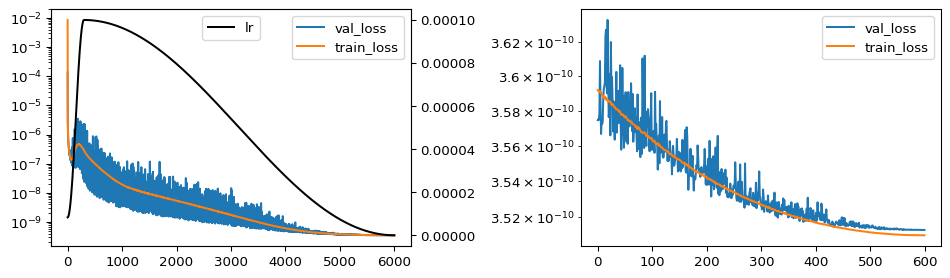

In [37]:
fig,ax=plt.subplots(1,2,figsize=(10,3),dpi=96)
ax[0].semilogy(history['val_loss'],label='val_loss')
ax[0].semilogy(history['train_loss'],label='train_loss')
ax[0].legend()
axx = ax[0].twinx()
axx.plot(history['lr'],label='lr',color='k')
axx.legend(loc='upper center')

ax[1].semilogy(history['val_loss'][-int(0.1*EPOCHs):],label='val_loss')
ax[1].semilogy(history['train_loss'][-int(0.1*EPOCHs):],label='train_loss')
ax[1].legend()
fig.tight_layout()

In [38]:
np.min(history['train_loss']), np.min(history['val_loss'])

(3.509474384524471e-10, 3.5124591953977245e-10)

# loaded model test, w jit, 

In [39]:
model_info = json.load(open(MODEL_PATH + 'model_info.json','r'))
scalar = util.scalar(fname=MODEL_PATH + 'scalar_info.pkl')

### model time cost

##### w/o JIT

In [40]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
model.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
model.eval();

In [41]:
test_x = torch.tensor(xn[:1,:],dtype=DTYPE)

def test():
    model(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 152.39148387685418 micro-sec


##### w JIT

In [42]:
model, _ = util.construct_model(**model_info)
model.to('cpu').to(DTYPE);
my_script_module = torch.jit.script(model)
my_script_module.load_state_dict(torch.load(MODEL_PATH+'model.pt',map_location=torch.device('cpu')))
my_script_module.eval();

In [43]:
def test():
    my_script_module(test_x)
t = timeit.Timer(test)
dt = t.timeit(number=100000)/100000
print('dt:',dt*1e6,'micro-sec')

dt: 111.41772959381342 micro-sec


# validation

In [44]:
nval = int(validation_split*len(x))
xval = xn[:nval]
yval = yn[:nval]
yval_true_phys = y[:nval]

xval.shape, yval.shape, yval_true_phys.shape

((40265318, 4), (40265318, 2), (40265318, 2))

In [45]:
BATCH_SIZE, nval, len(x)

(8192, 40265318, 134217728)

In [46]:
nbatch = int(len(xval)/BATCH_SIZE)
yval_pred = []
for i in range(nbatch):
    i1 = i*BATCH_SIZE
    i2 = i1+BATCH_SIZE
    x_ = torch.tensor(xval[i1:i2,:],dtype=DTYPE)
    with torch.no_grad():
        yval_pred.append( my_script_module(x_).cpu().numpy() )
        
x_ = torch.tensor(xval[i2:,:],dtype=DTYPE)
with torch.no_grad():
    yval_pred.append( my_script_module(x_).cpu().numpy() )
    
yval_pred_phys = scalar.unnormalize_y(np.concatenate(yval_pred,axis=0))

In [47]:
yval_pred_phys.shape, yval_true_phys.shape

((40265318, 2), (40265318, 2))

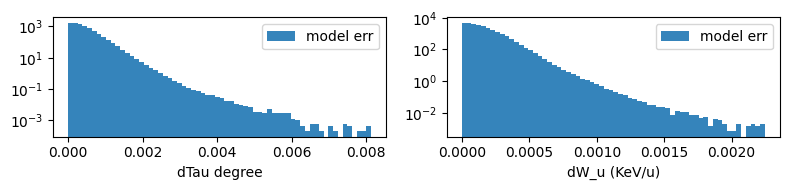

In [48]:
diff_model = np.abs(yval_pred_phys-yval_true_phys)

fig,ax = plt.subplots(1,2,figsize=(8,2))
ax[0].hist(diff_model[:,0]/np.pi*180,bins=64,label='model err',alpha=0.9,density=True)
ax[0].legend()
ax[0].set_yscale('log')
ax[0].set_xlabel(Y_LABELs[0]+" degree")

ax[1].hist(diff_model[:,1]*1e-5,bins=64,label='model err',alpha=0.9,density=True)
ax[1].legend()
ax[1].set_yscale('log')
ax[1].set_xlabel(Y_LABELs[1]+" (KeV/u)")

fig.tight_layout()
fig.savefig(MODEL_PATH+'plot_validation.png',dpi=64)